# Train a CNN on LSE cycles

In [1]:
# Imports
import tables
import os
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
np.random.seed(42)

import threading
import pickle
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
# =============================================================================
# PARAMETERS
# =============================================================================
labels_of_interest = ["heartAgeDataGender"]  #["heartCondition"]

#File locations
output_dir = "/scratch/PI/euan/projects/mhc/code/daniel_code/results"
label_table_file = "/scratch/PI/euan/projects/mhc/code/daniel_code/tables/combined_health_label_table.pkl"
label_table_file = "/scratch/PI/euan/projects/mhc/code/daniel_code/tables/all.tsv"
train_data_path = r"/scratch/PI/euan/projects/mhc/code/daniel_code/data/gender_subset_cycles.hdf5"

#Training metrics
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
model_metrics = ['accuracy',tpr,tnr,fpr,fnr,precision,f1]

#Training parameters
batch_size = 256
canMultiprocess = False

/scratch/users/danjwu/miniconda3/lib/python3.6/site-packages/concise/utils/plot.py:115: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/scratch/users/danjwu/miniconda3/lib/python3.6/site-packages/concise/utils/plot.py:116: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [3]:
#Look at what the data file looks like
with tables.open_file(train_data_path, mode='r') as file:
    print(file)
    
    #Test various data access schemes
    import timeit
    
    idxs = np.random.randint(0, 32006, size=(320,))
        
    #timeit.timeit(stmt='print(file.root.data[:50])', number=10)
    #%timeit e = [file.root.data[i] for i in range(320)]
    #print(idxs)
    #%timeit e = [file.root.data[i] for i in idxs]


/scratch/PI/euan/projects/mhc/code/daniel_code/data/gender_subset_cycles.hdf5 (File) 'cycles'
Last modif.: 'Thu Jul  4 02:21:11 2019'
Object Tree: 
/ (RootGroup) 'cycles'
/data (EArray(29586, 100, 4)) ''
/labels (EArray(29586,)) ''



(100, 300)


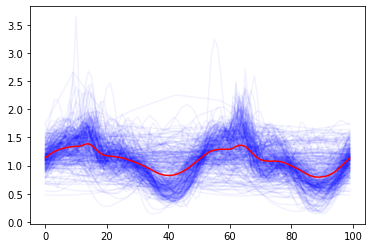

In [4]:
#Visualize some data points
with tables.open_file(train_data_path, mode='r') as file:
    subset = file.root.data[0:300, :, -1].T
    print(subset.shape)
    plt.plot(subset, color='b', alpha=0.05)
    plt.plot(np.mean(subset, axis=1), color ='r')

In [5]:
#Look at our label file
label_df = pd.read_csv(label_table_file, 
                       header=None,
                       names=["Healthcode", "Age", "Gender", "Ethnicity", "Version"], 
                       delimiter='\t')
label_df = label_df.set_index('Healthcode')
label_df
#Access a label like this
print(label_df.loc[label_df.index[0], 'Gender'])

Healthcode
d04c954e-979b-4b24-999a-aa4c4a9f90e9    Male
d04c954e-979b-4b24-999a-aa4c4a9f90e9    Male
Name: Gender, dtype: object


(256, 1, 4, 100)


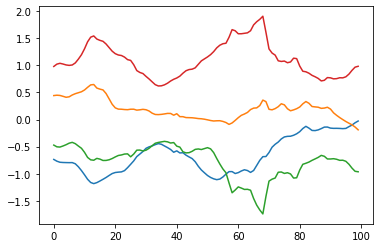

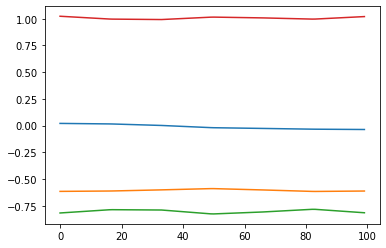

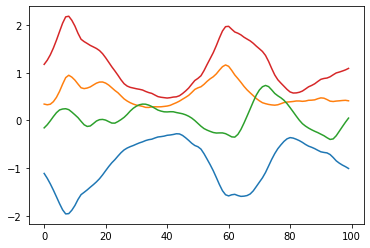

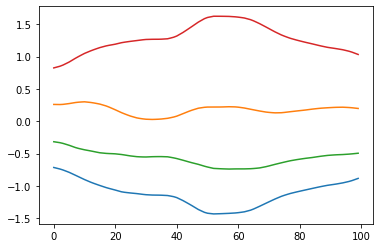

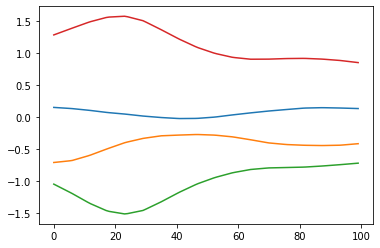

In [6]:
# =============================================================================
# Data generator
# =============================================================================
def extract_labels(labels, label_table_path):
    '''
    Returns a dataframe indexed by healthCodes with columns of requested labels
    taken from the label table file
    '''
    label_df = pd.read_csv(label_table_file, 
                           header=None,
                           names=["Healthcode", "Age", "Gender", "Ethnicity", "Version"], 
                           delimiter='\t')
    #Encode to bytes
    label_df['Healthcode'] = label_df['Healthcode'].map(lambda x: x.encode('UTF-8'))
    #Drop duplicates
    label_df = label_df.set_index('Healthcode')
    label_df = label_df.loc[~label_df.index.duplicated(keep='first')]
    return label_df

def parse_label(code, label_df):
    """
    Helper function that parses the labels on survey data for a given code
    """
    
    return label_df.loc[code, 'Gender'] == "Male"
        
class SixMWTSequence(keras.utils.Sequence):
    '''
    SixMWTSequence
    Extends keras inbuilt sequence to create a data generator
    Saves on RAM by loading data from hdf5 files in memory
    Shuffle increases read time by 20x but makes the batches mixed
    '''
    def __init__(self, data_file, batch_size, label_df, shuffle=True, val=False, val_split = 0.7):
        #Open up file
        #self.lock = threading.Lock()
        self.data = data_file.root.data
        self.labels = data_file.root.labels
        
        #Track labels and batch size
        self.label_map = label_df
        self.batch_size = batch_size
        self.inval_hc = set()
        self.val = val
        self.val_split = val_split
        
        #Partition the dataset into batches
        if val:
            num_data = int(self.labels.shape[0] * (1-val_split))
            self.order = np.arange(self.labels.shape[0] - num_data, self.labels.shape[0])
        else:
            num_data = int(self.labels.shape[0] * val_split)
            self.order = np.arange(num_data)
            
        self.length = num_data // self.batch_size
                
        #Shuffle
        if(shuffle):
            np.random.shuffle(self.order)        

    def __len__(self):

        return self.length

    def __getitem__(self, idx):
        
        start_idx = idx*self.batch_size
        stop_idx = (idx + 1)*self.batch_size
                    
        idxs = self.order[start_idx:stop_idx]
        
        #Get the batch members
        batch_x = np.array([self.data[idx] for idx in idxs])
        y_healthcodes = np.array([self.labels[idx] for idx in idxs])
                
        #Convert healthcodes to genders
        batch_y = np.empty(len(y_healthcodes), dtype = bool)
        for i in range(len(batch_y)):
            try:
                batch_y[i] = parse_label(y_healthcodes[i], self.label_map)
                
            except KeyError:
                #Currently just assign random gender. This is a dumb idea.
                #print(f"Invalid Healthcode: {y_healthcodes[i]}")
                self.inval_hc.add(y_healthcodes[i])
                batch_y[i] = bool(random.randint(0,1))

        #Normalize over time dimension
        #print(np.mean(batch_x, axis = -2))

        #batch_x -= np.expand_dims(np.mean(batch_x, axis = 1), axis=1)
        #batch_x = keras.utils.normalize(batch_x, axis=2)
        #print(np.mean(batch_x, axis = -2))
            
        #Add a extra dimension
        batch_x = np.expand_dims(batch_x, axis=1)
        #Swap axes
        batch_x = np.swapaxes(batch_x, -1, -2)
            
        return batch_x, batch_y

label_df = extract_labels(labels_of_interest, label_table_file)
#Look at what the data file looks like
with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)    
    print(train_gen[20][0].shape)
    window = train_gen[20][0]
    
    for i in range(5):
        plt.figure()
        plt.plot(window[i, :, :].squeeze().T)
        plt.show()

In [7]:
#Define a model
def get_model():
    model = Sequential()
    # ENTRY LAYER
    model.add(Conv1D(32, 10, activation='relu', input_shape=(100, 4)))
    model.add(BatchNormalization())

    for i in range(5):
    
        model.add(Conv1D(64, 5, activation='relu'))
        model.add(BatchNormalization())

    model.add(Conv1D(128, 10, activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv1D(128, 10, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(40, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [8]:
#Get a pretrained model and modify
def get_mod_model():
    from keras.models import load_model
    base_model = load_model("DummyModel.h5")
    model = Sequential()
    for layer in base_model.layers[:-2]:
        model.add(layer)
        
    model.add(Dense(1, activation='sigmoid'))
    return model

In [11]:
#Set the model up
model = get_mod_model()

print(model.summary())

#Define optimizer
adam = keras.optimizers.Adam() #Default lr is 0.001

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=model_metrics)

#Make a baby validation dataset in memory for tensorboard callback
X_val = np.empty((0, 1, 4, 100))
y_val = np.empty((0,))

with tables.open_file(train_data_path, mode='r') as file:
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)  
    for batch_x, batch_y in val_gen:
        X_val = np.concatenate((X_val, batch_x), axis=0)
        y_val = np.concatenate((y_val, batch_y), axis=0)

#Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-7, verbose=1)

early_stop = EarlyStopping(patience=8, verbose=1, restore_best_weights=True)

tb = TensorBoard(log_dir=os.path.join(output_dir, 'logs'), 
                 write_graph=False, 
                 #histogram_freq=5, 
                 embeddings_freq=5, 
                 embeddings_layer_names=['avgpool'],
                 embeddings_data = X_val)

cb_list = [reduce_lr, early_stop, tb]



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
swapaxes_acc (Permute)       (None, 1, 100, 4)         0         
_________________________________________________________________
block1_conv1_acc (Conv2D)    (None, 1, 100, 32)        416       
_________________________________________________________________
block1_bn1_acc (BatchNormali (None, 1, 100, 32)        128       
_________________________________________________________________
block1_act1_acc (ELU)        (None, 1, 100, 32)        0         
_________________________________________________________________
block1_conv2_acc (Conv2D)    (None, 1, 100, 32)        3104      
_________________________________________________________________
block1_bn2_acc (BatchNormali (None, 1, 100, 32)        128       
_________________________________________________________________
block1_act2_acc (ELU)        (None, 1, 100, 32)        0         
__________

In [12]:
# =============================================================================
# Training the model
# =============================================================================

with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)    
    
    num_train = len(train_gen)
    num_val = len(val_gen)
    print("There are {} training batches and {} validation batches".format(num_train, num_val))
    
    num_epochs = 1000
    
    #Calculate class weights from 100 batches
    temp = np.array([])
    num_smpls = min(100, num_train)
    rand_idxs = random.sample(list(range(num_train)), num_smpls)
    for batch_num in rand_idxs:
        _, temp_y = train_gen[batch_num]
        temp = np.concatenate((temp, temp_y))
    class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
                                                     np.unique(temp),
                                                     temp)))
    
    print("Our class weights are {}".format(class_weights))
    #Training

    history = model.fit_generator(generator=train_gen,
                              epochs=num_epochs,
                              callbacks = cb_list,
                              validation_data=val_gen,
                              class_weight=class_weights,
                              shuffle=True)

There are 80 training batches and 34 validation batches
Our class weights are {0: 1.258758451137062, 1: 0.829485621709194}


AttributeError: Layer avgpool has multiple inbound nodes, hence the notion of "layer output" is ill-defined. Use `get_output_at(node_index)` instead.

# Visualize Results

In [ ]:
#Example predictions
pred = model.predict_on_batch(window)
print(f"{pred.sum()/len(pred)} of the predictions were 1 (Male)")

In [ ]:
plt.figure()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

In [ ]:
train_gen.inval_hc.union(val_gen.inval_hc)

In [ ]:
#Evaluate model on validation set
with tables.open_file(train_data_path, mode='r') as file:
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)  
    y_test = np.empty((0,))
    y_pred = np.empty((0,))
    for batch_x, batch_y in val_gen:
        pred = model.predict_on_batch(batch_x)
        y_test = np.concatenate((y_test, batch_y))
        y_pred = np.concatenate((y_pred, pred.squeeze()))
        print("Batch")

In [ ]:
print(y_pred.round() == y_test)

In [ ]:
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(25,25)) 
df_results=pd.DataFrame(data=np.column_stack((y_test,y_pred.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.heatmap(CT_results, annot=True, fmt=".2f", linewidths=.5,ax=ax)

# That's it folks!

In [ ]:
#Save the model
model.save("6_9_19.h5")